In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Dataset Generation

In [3]:
def pendulum_dynamics(x, u, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  theta, omega = x
  m, l, g = params["m"], params["l"], params["g"]
  u = float(u)

  d_theta = omega
  d_omega = (g/l) * np.sin(theta) + u/(m * l**2)

  return np.array([d_theta, d_omega])

def rk4_step(f, x, u, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  k1 = f(x, u, params)
  k2 = f(x + 0.5 * dt * k1, u, params)
  k3 = f(x + 0.5 * dt * k2, u, params)
  k4 = f(x + dt * k3, u, params)

  return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, u_control, dt, T, params):
  N = int(T/dt)
  x = np.zeros((N+1, 2))
  x[0] = x0

  for t in range(N):
    x[t+1] = rk4_step(pendulum_dynamics, x[t], u_control[t], dt, params)
  return x

In [23]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

T = 10.0  # = 10s
dt = 0.005  # 2 000 step
n_traj = 10  #  20 000 points

#------------
# Storage
#------------
X = []
H = []
traj_IDs = []

#-------------------
# Data generation
#-------------------

for k in range(n_traj):
  theta0 = np.random.uniform(-np.pi, np.pi)  #random initialisation of the angle
  omega0 = np.random.uniform(-1.0, 1.0)      #random initialisation of the angular velocity
  u_traj = np.zeros((int(T/dt),1))
  x0 = np.array([theta0, omega0])

  traj = trajectory_simulation(x0, u_traj, dt, T, params)

  X.append(traj[:-1]) # We don't include the last one because there is no future state to predict
  H.append( (1/2) * traj[:-1,1]**2 + (1 - np.cos(traj[:-1,0])))
  traj_IDs.append( k * np.ones(int(T/dt), dtype=int) )

X = np.concatenate(X, axis=0)
H = np.concatenate(H, axis=0)
traj_IDs = np.concatenate(traj_IDs)

print(X.shape)
print(H.shape)
print(traj_IDs.shape)
#------------
#   Save
#------------

np.savez(
         "HNN_dataset.npz",
         X=X,   # shape (N * (T / dt),2)
         Y=H,   # shape (N * (T / dt), 1)
         traj_ID=traj_IDs,   # shape (N * (T / dt), 1)
         dt=dt
         )

/tmp/ipython-input-1061426118.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(u)


(20000, 2)
(20000,)
(20000,)


In [24]:
data = np.load("HNN_dataset.npz")

print("Available keys:", data.files)  # Lists all keys in the archive
traj_IDs = data["traj_ID"]
unique_traj = np.unique(traj_IDs)

np.random.seed(42)
np.random.shuffle(unique_traj)

n_train = int(0.8 * len(unique_traj))
train_traj = unique_traj[:n_train]  # training dataset contain 80% of all the data
test_traj = unique_traj[n_train:]   # test dataset contain 20% of all the data

train_idx = np.isin(traj_IDs, train_traj)
test_idx = np.isin(traj_IDs, test_traj)

np.savez(
    "HNN_splits.npz",
    train_idx=train_idx,
    test_idx=test_idx
)   # Contain the IDs of the test trajectory and of the train trajectory

Available keys: ['X', 'Y', 'traj_ID', 'dt']


(20000, 2)
(20000, 2)


(array([  73.,   89.,   98.,   70.,   60.,   57.,  220.,  126.,  109.,
         200.,  446.,  457.,  336.,  296.,  279.,  450.,  427.,  371.,
         359.,  882.,  796.,  665., 1037., 1010.,  940.,  945., 1006.,
        1038.,  691.,  809.,  904.,  376.,  397.,  442.,  457.,  299.,
         321.,  362.,  507.,  468.,  187.,  114.,  132.,  224.,   62.,
          68.,   78.,   99.,   87.,   74.]),
 array([-6.24930748e+00, -5.99933520e+00, -5.74936292e+00, -5.49939064e+00,
        -5.24941836e+00, -4.99944608e+00, -4.74947380e+00, -4.49950151e+00,
        -4.24952923e+00, -3.99955695e+00, -3.74958467e+00, -3.49961239e+00,
        -3.24964011e+00, -2.99966783e+00, -2.74969555e+00, -2.49972326e+00,
        -2.24975098e+00, -1.99977870e+00, -1.74980642e+00, -1.49983414e+00,
        -1.24986186e+00, -9.99889577e-01, -7.49917296e-01, -4.99945014e-01,
        -2.49972733e-01, -4.51953158e-07,  2.49971829e-01,  4.99944111e-01,
         7.49916392e-01,  9.99888673e-01,  1.24986095e+00,  1.499833

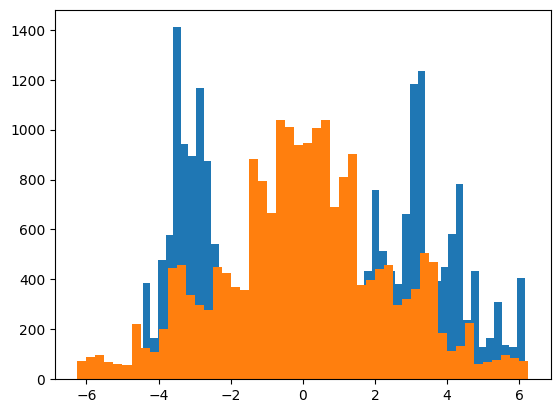

In [26]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}
#-------------
# Dataset
#-------------

data = np.load("HNN_dataset.npz")
split = np.load("HNN_splits.npz")

X = np.hstack([data["X"]])
Y = np.array([X[:,1], -(params["g"]/params["l"])*np.sin(X[:,0])]).T

X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

print(X.shape)
print(Y.shape)
plt.hist(X[:,0],bins = 50)
plt.hist(X[:,1],bins = 50)